# Independent Component Analysis

A computational method for separating a multivariate signal into its underlying components. Using ICA, the desired component can be extracted.

## Algorithm for ICA

1. Center **x** by subtracting the mean.
2. Whiten **x**.
3. Choose a random initial value for the de-mixing matirx **W**.
4. Calculate the new value for **W**.
5. Normalize **W**.
6. Check whether algorithm has converged and is it hasn't, return to step 4. Convergence condition is when dot product of W and W.T is approximately equal to one.
7. Take the dot product of **W** and **x** to get the independed source signals.

Extracted Signals, **S** = **W** * **x**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import signal
from scipy.io import wavfile

np.random.seed(0)
sns.set(rc={'figure.figsize':(11.7,8.27)})

Calculating g and g' for calculating the new value of W.

In [2]:
def g(x):
    return np.tanh(x)

In [3]:
def g_der(x):
    return 1 - g(x)**2

Centering the mean by subtracting the mean

In [14]:
def center_x(x):
    
    x = np.array(x)
    mean = x.mean(axis=1, keepdims=True)
    
    return x - mean
    pass

Whitening the signal

In [6]:
def whiten_x(x):
    
    cov = np.cov(x)
    
    d, E = np.linalg.eigh(cov)
    
    D = np.diag(d)
    
    D_inv = np.sqrt(np.linalg.inv(D))
    
    x_whiten = np.dot(E, np.dot(D_inv, np.dot(E.T,x)))

    return x_whiten
    pass

Calculating the weight W.

In [7]:
def calculate_w_new(w, X):
    
    w_new = (X * g(np.dot(w.T,X))).mean(axis=1) - g_der(np.dot(w.T, X)).mean() * w
    
    w_new /= np.sqrt((w_new**2).sum())
    
    return w_new
    pass

Implementing the ICA algorithm

In [9]:
def ica(X, iterations, tolerance=1e-5):
    
    X = center_x(X)
    
    X = whiten_x(X)
    
    components_nr = X.shape[0]
    
    W = np.zeros((components_nr, components_nr), dtype = X.dtype)
    
    for i in range(components_nr):
        
        w = np.random.rand(components_nr)
        for j in range(iterations):
            
            w_new = calculate_w_new(w, X)
            
            if i>=1:
                w_new -= np.dot(np.dot(w_new, W[:i].T),W[:i])
            
            distance = np.abs(np.abs((w * w_new).sum()) - 1)
            w = w_new
            
            if distance < tolerance:
                break
            pass
        
        W[i,:] = w
        pass
    
    S = np.dot(W,X)
    return S
    pass

In [20]:
def plot_mixture_sources_prediction(X, original_sources, S):
    
    fig = plt.figure()
    
    plt.subplot(3, 1, 1)
    for x in X:
        plt.plot(x)
        pass
    plt.title("mixtures")
    
    plt.subplot(3, 1, 2)
    for s in original_sources:
        plt.plot(s)
        pass
    plt.title("real sources")
    
    plt.subplot(3, 1, 3)
    for s in S:
        plt.plot(s)
        pass
    plt.title("predicted sources")
    
    fig.tight_layout()
    plt.show();
    pass

In [11]:
def mix_sources(mixtures, apply_noise=False):
    for i in range(len(mixtures)):
        
        max_val = np.max(mixtures[i])
        
        if max_val > 1 or np.min(mixtures[i]) < 1:
            
            mixtures[i] = mixtures[i] / (max_val / 2) - 0.5
            
    X = np.c_[[mix for mix in mixtures]]
    
    if apply_noise:
        
        X += 0.02 * np.random.normal(size=X.shape)
        
    return X

In [12]:
n_samples = 2000
time = np.linspace(0, 8, n_samples)
s1 = np.sin(2 * time) # sinusodial
s2 = np.sign(3 * time) # square signal
s3 = signal.sawtooth(2* np.pi * time) # saw tooth signal

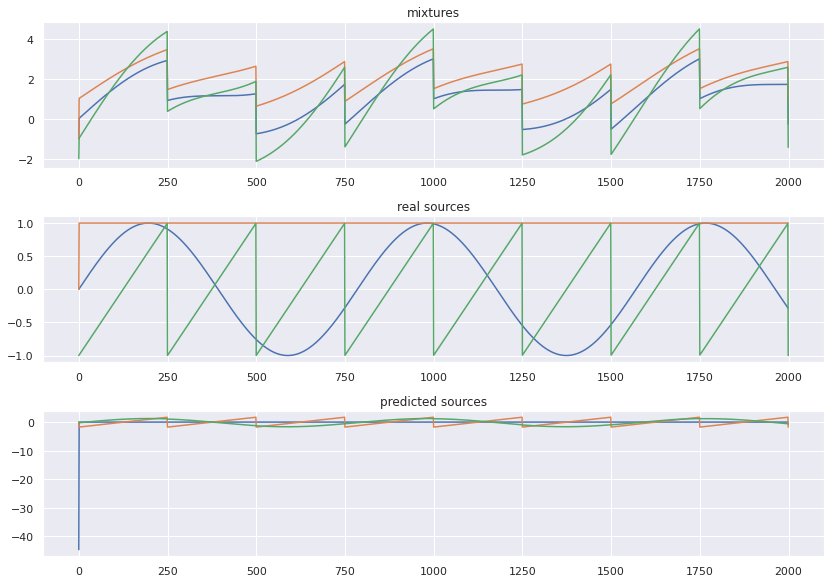

In [21]:
X = np.c_[s1,s2,s3]

A = np.array(([[1, 1, 1], [0.5, 2, 1.0], [1.5, 1.0, 2.0]]))
X = np.dot(X, A.T)
X = X.T

S = ica(X, iterations=1000)
plot_mixture_sources_prediction(X, [s1,s2,s3], S)

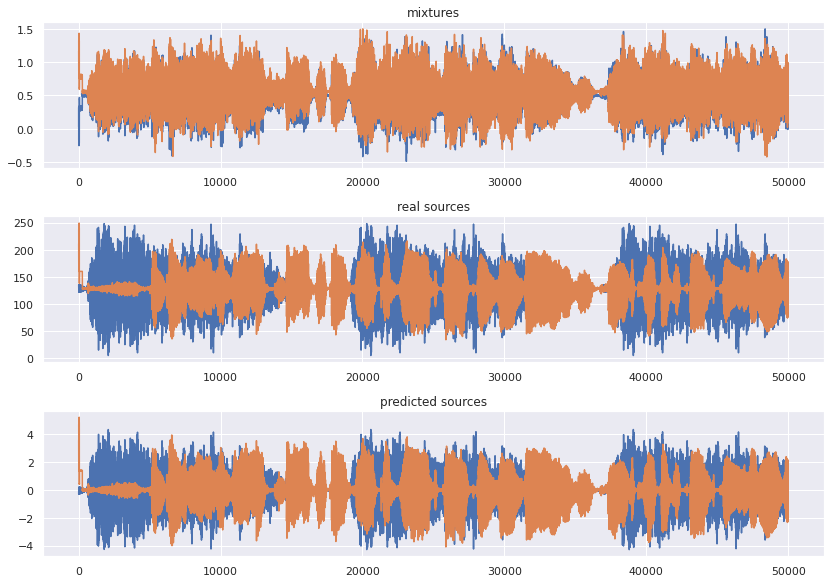

In [22]:
sampling_rate, mix1 = wavfile.read('mix1.wav')
sampling_rate, mix2 = wavfile.read('mix2.wav')
sampling_rate, source1 = wavfile.read('source1.wav')
sampling_rate, source2 = wavfile.read('source2.wav')

X = mix_sources([mix1,mix2])
S = ica(X, iterations=1000)

plot_mixture_sources_prediction(X, [source1,source2], S)

wavfile.write('out1.wav', sampling_rate, S[0])
wavfile.write('out2.wav', sampling_rate, S[1])